
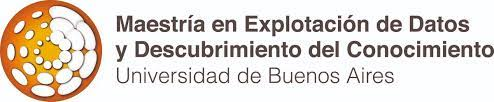

--------
#      **_Data mining en Ciencia y Tecnología_**
                2do cuatrimestre 2021 
                TRABAJO PRÁCTICO Nº 2
                  REDES DE PALABRAS


**GRUPO 7**

<u>**Integrantes**</u>:

* Rossi, Fabiana Alejandra
* Rodrigues Pires, Magali
* Padula, Eliana Inés
* López Malizia, Álvaro
--------

LINK TP OVERLEAF: https://es.overleaf.com/project/61acc0bad12df7cba96f7e14

# Librerías, funciones y datos

In [1]:
 !pip install networkx powerlaw community

In [2]:
#Librerias para visualización
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

# Números y Datos
import numpy as np
import pandas as pd
import networkx as nx

#Librerías para grafos
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import community
#import powerlaw
from sklearn.metrics import adjusted_rand_score

**Drive en el COLAB**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Funcion para la visualización**

In [4]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 

def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

# TRABAJO PRÁCTICO NRO 2

# **Tarea 1: Construcción de los grafos**

# GSWW

## Preprocesamiento de Gsww

In [5]:
# Se cargan los datos
SmallWorldofWords= pd.read_csv('/content/drive/MyDrive/CyT_2021/TP2/SWOW-EN.R100.csv') 
SmallWorldofWords.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [6]:
# FILTRO 1: Se eliminan todas las columnas salvo CUE y R1
df_words=SmallWorldofWords.drop(['Unnamed: 0','id','participantID','age','gender','nativeLanguage','country','education','created_at', 'R2','R3'], axis=1)

In [7]:
# Análisis de faltantes 
print('La/s categorías que tienen nulls son:')
df_words[df_words.columns[df_words.isnull().any()]].isnull().sum() 

La/s categorías que tienen nulls son:


cue      100
R1     31096
dtype: int64

In [8]:
# FILTRO 2: Remoción de NAs
df_limpio=df_words.dropna()

# Cantidad de datos
df_limpio.describe()

,cue,R1
count,1197008,1197008
unique,12281,64822
top,livestock,money
freq,100,6070


In [9]:
# FILTRO 3: Eliminación de palabras de 1 letra
df = df_limpio.copy(deep=True)
df.drop(df[df['cue'].str.len().lt(2)].index, inplace=True)
df.drop(df[df['R1'].str.len().lt(2)].index, inplace=True)

In [10]:
# FILTRO 4: Remoción de palabra de cue1 que no se encuentren en R1 y viceversa
df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)

In [11]:
# FILTRO 5: Eliminación los stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df.replace(stop,np.NaN,regex=False,inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


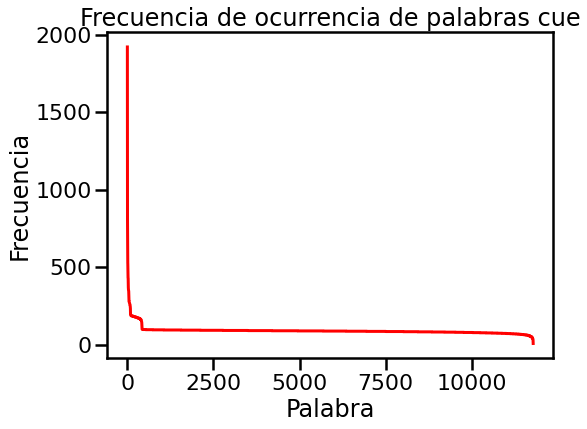

In [12]:
# Análisis gráfico de frecuencia de la palabra 'cue'

new_dfR = df['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_dfR.columns = ['Word', 'Frequency'] 
new_dfR['Frequency'].plot(color='red')
plt.ylabel('Frecuencia')
plt.xlabel('Palabra');
plt.title('Frecuencia de ocurrencia de palabras cue');

In [13]:
prueba=df.groupby(['cue', 'R1']).size().reset_index().rename(columns={0:''})
prueba.columns = ['cue', 'R1', 'Frequency_pares'] 
prueba=prueba.sort_values('Frequency_pares')
prueba.tail()

,cue,R1,Frequency_pares
219679,mozzarella,cheese,86
157973,halt,stop,87
217547,moo,cow,91
6927,Parmesan,cheese,92
1617,Cheddar,cheese,93


In [14]:
print('min "Frequency_pares":', min(prueba.Frequency_pares))
print('max "Frequency_pares":', max(prueba.Frequency_pares))
print('media:',np.mean(prueba.Frequency_pares))
print('mediana:',np.median(prueba.Frequency_pares))
print('percentil 75%:',np.percentile(prueba.Frequency_pares,75))
print('percentil 80%:',np.percentile(prueba.Frequency_pares,80))
print('percentil 85%:',np.percentile(prueba.Frequency_pares,85))
print('percentil 90%:',np.percentile(prueba.Frequency_pares,90))
print('percentil 95%:',np.percentile(prueba.Frequency_pares,95))
print('percentil 97.5%:',np.percentile(prueba.Frequency_pares,97.5))
print('percentil 98%:',np.percentile(prueba.Frequency_pares,98))
print('percentil 98.5%:',np.percentile(prueba.Frequency_pares,98.5))
print('percentil 99%:',np.percentile(prueba.Frequency_pares,99))

min "Frequency_pares": 1
max "Frequency_pares": 93
media: 2.750685873799221
mediana: 1.0
percentil 75%: 2.0
percentil 80%: 3.0
percentil 85%: 4.0
percentil 90%: 5.0
percentil 95%: 10.0
percentil 97.5%: 17.0
percentil 98%: 19.0
percentil 98.5%: 23.0
percentil 99%: 29.0


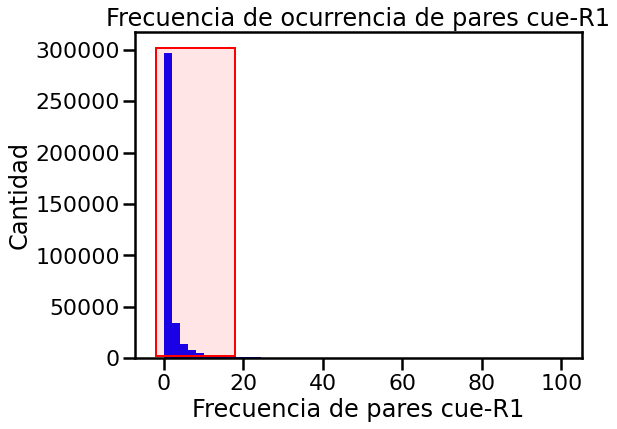

In [15]:
# Gráfico de frecuencia de ocurrencia de pares
frecuencia_de_pares=prueba.Frequency_pares
plt.hist(frecuencia_de_pares,bins=np.linspace(0,100), color='blue')
plt.ylabel('Cantidad')
plt.xlabel('Frecuencia de pares cue-R1');
plt.title('Frecuencia de ocurrencia de pares cue-R1');

import matplotlib.patches as mpatches
rect=mpatches.Rectangle((-2,2000),20,300000, 
                        fill = 'red', alpha=0.1,
                        color = "red",
                        linewidth = 2)
rect1=mpatches.Rectangle((-2,2000),20,300000, 
                        fill = False,
                        color = "red",
                        linewidth = 2)
plt.gca().add_patch(rect)
plt.gca().add_patch(rect1)

In [16]:
# FILTRO 6: Se eliminan CUE que aparecen hasta 23 veces (sólo quedan >23)
df_20 = df.groupby(['cue']).filter(lambda x: len(x) > 23) ## percentil 98.5
df_20.shape

(1049541, 2)

In [17]:
# FILTRO 7: Se eliminan pares CUE-R1 cuya frecuencia sea muy pequeña respecto CUE 

# Análisis de frecuencia
df_20.head()

freq_par = df_20.groupby(['cue', 'R1']).size()
df_20A=freq_par.to_frame(name = 'freq_par').reset_index()
df_20A

,cue,R1,freq_par
0,Abel,Cain,55
1,Abel,baker,1
2,Abel,cane,4
3,Abel,catholic,1
4,Abel,farm,1
...,...,...,...
375049,zucchini,plant,1
375050,zucchini,soup,1
375051,zucchini,squash,12
375052,zucchini,vegetable,18


In [18]:
freq_R1 = df_20.groupby('R1').count()
freq_cue = df_20.groupby('cue').count()

In [19]:
df_20B=pd.merge(df_20A, freq_R1, on='R1', how='outer')
df_20B.columns = ['cue', 'R1', 'freq_par','freq_R1'] 
df_20C=pd.merge(df_20B, freq_cue, on='cue', how='outer')
df_20C.columns = ['cue', 'R1', 'freq_par','freq_R1','freq_cue'] 

In [20]:
df_20C['cue-R1/cue']=df_20C['freq_par']/df_20C['freq_cue']

df_20C

,cue,R1,freq_par,freq_R1,freq_cue,cue-R1/cue
0,Abel,Cain,55,62,72,0.763889
1,Abel,baker,1,24,72,0.013889
2,Abel,cane,4,112,72,0.055556
3,Abel,catholic,1,207,72,0.013889
4,Abel,farm,1,388,72,0.013889
...,...,...,...,...,...,...
375049,maybe,glucose,1,11,79,0.012658
375050,maybe,possibly,6,23,79,0.075949
375051,maybe,so so,1,9,79,0.012658
375052,maybe,permissive,1,7,79,0.012658


In [21]:
# FILTRO 7: Se eliminan pares CUE-R1/cue 98.5%

print('min:',min(df_20C['cue-R1/cue'])) 
print('max:',max(df_20C['cue-R1/cue'])) 
print('media:',np.mean(df_20C['cue-R1/cue']))
print('mediana:',np.median(df_20C['cue-R1/cue']))
print('percentil 75%:',np.percentile(df_20C['cue-R1/cue'],75))
print('percentil 80%:',np.percentile(df_20C['cue-R1/cue'],80))
print('percentil 85%:',np.percentile(df_20C['cue-R1/cue'],85))
print('percentil 90%:',np.percentile(df_20C['cue-R1/cue'],90))
print('percentil 95%:',np.percentile(df_20C['cue-R1/cue'],95))
print('percentil 97.5%:',np.percentile(df_20C['cue-R1/cue'],97.5))
print('percentil 98%:',np.percentile(df_20C['cue-R1/cue'],98))
print('percentil 98.5%:',np.percentile(df_20C['cue-R1/cue'],98.5))
print('percentil 99%:',np.percentile(df_20C['cue-R1/cue'],99))


df_prev=df_20C[df_20C['cue-R1/cue'] > 0.267760311871225]
df_prev.shape

min: 0.01
max: 0.96875
media: 0.03211270910322598
mediana: 0.012345679012345678
percentil 75%: 0.024096385542168676
percentil 80%: 0.03260869565217391
percentil 85%: 0.043010752688172046
percentil 90%: 0.0625
percentil 95%: 0.11538461538461539
percentil 97.5%: 0.19540229885057472
percentil 98%: 0.2268041237113402
percentil 98.5%: 0.2676571931589578
percentil 99%: 0.3333333333333333


(5626, 6)

In [22]:
# FILTRO 8: Remoción de palabras que no se encuentren en w2v
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-12 20:52:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.71.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.71.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  72.0MB/s    in 19s     

2021-12-12 20:52:31 (84.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [23]:
len(w2v_model2.wv.vocab) # 3000000 palabras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


3000000

In [24]:
w2v_words=w2v_model2.index2word #depende de la versión (probar "index_to_key")

In [25]:
# Sacar palabras de la dataframe que no estén en las palabras de word2vec
df_prev.drop(df_prev[df_prev['R1'].isin(w2v_words)==False].index, inplace=True)
df_prev.drop(df_prev[df_prev['cue'].isin(w2v_words)==False].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
# FILTRO QUE NO SE UTILIZO: Se toma una muestra de 500 filas de mayor relación cue-r1/r1
df_sample = df_prev.sort_values('cue-R1/cue',ascending=False).iloc[0:1000]

## Creación de grafo Gsww

In [27]:
# Construcción de grafo pesado donde los nodos seran de CUE a R1 y los pesos la Frequency CUE-R1/R1
#digrafo del sample:
#G_sample=nx.DiGraph() 

G = nx.Graph() # no dirigido
for i in df_prev.index:
  G.add_weighted_edges_from([(df_prev['cue'][i],df_prev['R1'][i],df_prev['cue-R1/cue'][i])]) #Uso la tabla sin umbral

In [28]:
# FILTRO 8: grafo conexo
largest_cc = max(nx.connected_components(G), key=len)
G_sample = G.subgraph(largest_cc).copy() 
print(nx.info(G_sample))

Graph with 219 nodes and 221 edges


In [29]:
G_sample.edges(data=True) 

EdgeDataView([('bread', 'bakery', {'weight': 0.5425531914893617}), ('bread', 'rolls', {'weight': 0.3780487804878049}), ('bread', 'wheat', {'weight': 0.3333333333333333}), ('bread', 'crusty', {'weight': 0.3763440860215054}), ('bread', 'stale', {'weight': 0.4318181818181818}), ('bread', 'baker', {'weight': 0.33707865168539325}), ('bread', 'toaster', {'weight': 0.3333333333333333}), ('bread', 'toast', {'weight': 0.45652173913043476}), ('bread', 'baguette', {'weight': 0.46236559139784944}), ('bread', 'dough', {'weight': 0.2826086956521739}), ('bread', 'crumb', {'weight': 0.5368421052631579}), ('bread', 'loaf', {'weight': 0.8631578947368421}), ('bread', 'crust', {'weight': 0.34375}), ('bread', 'rye', {'weight': 0.6195652173913043}), ('bread', 'yeast', {'weight': 0.5888888888888889}), ('circulation', 'blood', {'weight': 0.6595744680851063}), ('lychee', 'fruit', {'weight': 0.28888888888888886}), ('pineapple', 'fruit', {'weight': 0.4117647058823529}), ('mortified', 'embarrassed', {'weight': 0.

## Caracterización de grafo Gsww

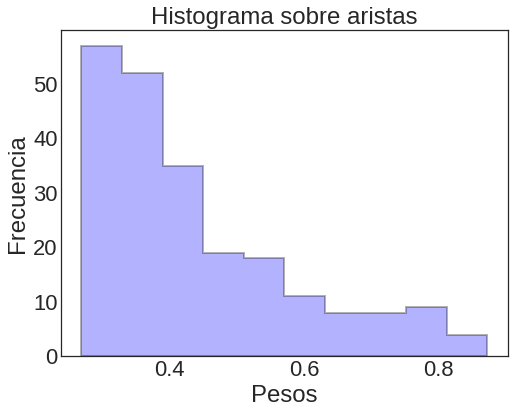

In [30]:
plt.style.use('seaborn-white')
kwargs = dict(histtype='stepfilled', alpha=0.3, ec="k")
#histograma
plt.figure()
nodo_salida = [n1 for n1, n2, att in G_sample.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_sample.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_sample.edges(data=True)]
#print(weights)
plt.hist(weights,color='blue',**kwargs);
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma sobre aristas');

In [31]:
# Análisis de red
print(nx.info(G_sample))
print('Pesada:',nx.is_weighted(G_sample))
print('Dirigido:',nx.is_directed(G_sample))
print('Nro de nodos: ',G_sample.number_of_nodes())
print('Cantidad de aristas: ', G_sample.number_of_edges())
print('Es multigrafo:',G_sample.is_multigraph())
print('Está conectada?: ',nx.is_connected(G_sample))

Graph with 219 nodes and 221 edges
Pesada: True
Dirigido: False
Nro de nodos:  219
Cantidad de aristas:  221
Es multigrafo: False
Está conectada?:  True


In [32]:
# Análisis de red, cálculo de la cantidad de loops
def is_self_looped(g, node):
    return node in g[node]

J=[]
for i in G_sample:
  J.append(is_self_looped(G_sample,i))
print('cantidad de loops: ',sum(J))

cantidad de loops:  0


In [33]:
# Para ver una lista de aristas o nodos
pd.DataFrame.from_dict(G_sample.edges).rename(columns={0:'from',1:'to'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
from,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,bread,circulation,lychee,pineapple,mortified,mature,wrinkle,wrinkle,bananas,bananas,commence,commence,seafood,senior,senior,tuna,charred,core,obsolete,Marxist,vampires,stickleback,embarrassed,embarrassed,immature,pie,...,termination,vampire,sushi,young,beginnings,activate,initiate,beetroot,blush,blush,dye,beets,burnt,blushing,orange,orange,orange,color,color,colors,cork,mustard,wine,wine,beet,ruby,pear,iPad,orchard,scarlet,start,burgundy,strawberries,communist,tomato,auburn,apples,lipstick,finally,mellow
to,bakery,rolls,wheat,crusty,stale,baker,toaster,toast,baguette,dough,crumb,loaf,crust,rye,yeast,blood,fruit,fruit,embarrassed,old,crinkle,old,yellow,fruit,begin,start,fish,junior,old,fish,burnt,apple,old,communist,blood,fish,red,ashamed,young,apple,...,end,Dracula,sashimi,youth,start,start,start,red,red,redden,color,red,toast,red,carrot,juice,carrots,red,pigment,red,wine,yellow,red,vine,red,red,prickly,apple,apple,red,originate,red,red,red,red,red,oranges,red,end,yellow


In [34]:
# Grado de los nodos
print(G_sample.degree)
dfn = pd.DataFrame(G_sample.degree,columns=['Node','Degree']).set_index('Node')
print(dfn.T)
#ordenados
print(dfn.sort_values('Degree',ascending=False).T)

[('bread', 15), ('circulation', 1), ('lychee', 1), ('dough', 1), ('pineapple', 1), ('mortified', 1), ('mature', 1), ('wrinkle', 2), ('bananas', 2), ('commence', 2), ('seafood', 1), ('senior', 2), ('tuna', 1), ('charred', 1), ('core', 1), ('obsolete', 1), ('Marxist', 1), ('vampires', 1), ('stickleback', 1), ('loaf', 1), ('embarrassed', 3), ('immature', 1), ('pie', 5), ('flounder', 1), ('vintage', 1), ('antique', 1), ('cutie', 1), ('finality', 1), ('rhubarb', 1), ('senile', 1), ('stale', 2), ('rind', 1), ('roses', 1), ('rouge', 1), ('conclude', 2), ('wheat', 3), ('fries', 1), ('retirement', 2), ('toaster', 2), ('trout', 1), ('beginning', 6), ('sardine', 1), ('innovative', 1), ('old', 34), ('hue', 1), ('fish', 21), ('catcher', 1), ('retired', 1), ('sunflower', 1), ('carp', 1), ('antiques', 1), ('pension', 1), ('plasma', 1), ('terminate', 1), ('sweetie', 1), ('bait', 1), ('donor', 1), ('baker', 1), ('conclusion', 1), ('apocalypse', 1), ('guitar', 2), ('plaice', 1), ('historic', 1), ('junio

Text(0.5, 1.0, 'spring')

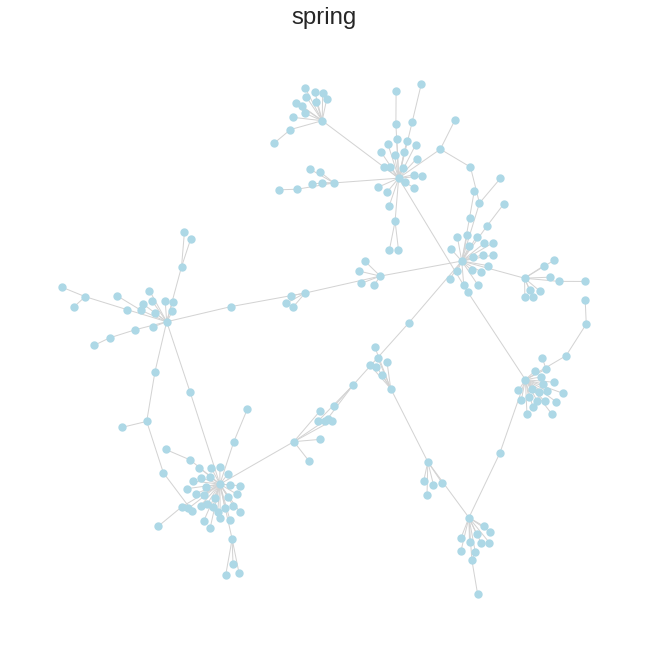

In [35]:
# Visualización
plt.figure(figsize=(25,25))
plt.subplot(221)
nx.draw(G_sample, with_labels=False,edge_color='lightgray',node_size=40, node_color='lightblue')
plt.title('spring')

#plt.subplot(222)
#layout=nx.kamada_kawai_layout(G_sample)
#nx.draw(G_sample,layout, with_labels=True,edge_color='lightgray',node_size=200, node_color='lightblue')
#plt.title('Kamada Kawai')
#plt.subplot(223)
#layout=nx.circular_layout(G_sample)
#nx.draw(G_sample,layout, with_labels=True,edge_color='lightgray',node_size=200, node_color='lightblue')
#plt.title('circular');
#plt.subplot(224)
#layout=nx.random_layout(G_sample)
#nx.draw(G_sample,layout, with_labels=True,edge_color='lightgray',node_size=200, node_color='lightblue')
#plt.title('random');

# GW2V

## Preprocesamiento de Gw2v

**3.2. Gw2v: word2vec**

Se carga el word2vec prentrenado que les proveemos (pero pueden buscar otro), a partir de él es posible definir la matríz de adyacencia, y a partir de esta el grafo.
Filtrar sólo las palabras que aparecen en Gsww. Si es necesario pueden realizar los filtros que consideren más adecuados.

In [36]:
# FILTRO 1: remoción de palabras que no se encuentren en Gsww
w2v_words3 = pd.Series(list(set(w2v_words).intersection(set(list(G_sample.nodes))))) 

In [37]:
# Creación de df para agregar palabras y su similaridad
columnas = ['word1', 'word2','similarity']
df_new = pd.DataFrame(columns=columnas)

Total de pares de palabras 23871
Palabra 0: 0.00 secs
(219, 219)


Text(0.5, 1.0, 'Matriz de distancias')

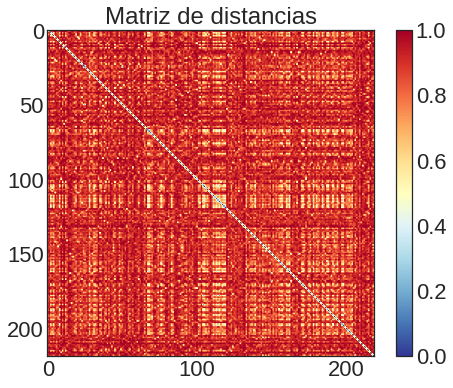

In [38]:
# Armado de una matriz de distancias basada en word2vec
# w2v_words3 = lista de palabras que van a ser el nodo de la red

distancias_w2v_dict=np.zeros((len(w2v_words3),len(w2v_words3))) 

t = time.time()
print('Total de pares de palabras %d'%(len(w2v_words3)*(len(w2v_words3)-1)/2))
for i,ti in enumerate(w2v_words3):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(w2v_words3):
    if j>i:
      similarity=abs(1-w2v_model2.similarity(ti,tj))
      distancias_w2v_dict[i,j] = similarity #
      df_new = df_new.append({'word1':w2v_words3[i] , 'word2':w2v_words3[j], 'similarity':similarity}, ignore_index=True)

distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

plt.imshow(distancias_w2v_dict,cmap='RdYlBu_r',vmax=1)
plt.colorbar()
plt.title('Matriz de distancias')

In [39]:
# opcional: guardado de matriz de distancias
# np.savetxt('distancias_w2v_dict.csv', distancias_w2v_dict, delimiter = ",")

In [40]:
distancias_w2v_dict.shape # (219,219)

(219, 219)

## Creación de grafo Gw2v

In [41]:
# Armado de grafo
G_w2v = nx.from_numpy_matrix(distancias_w2v_dict)

## Caracterización de grafo Gw2v

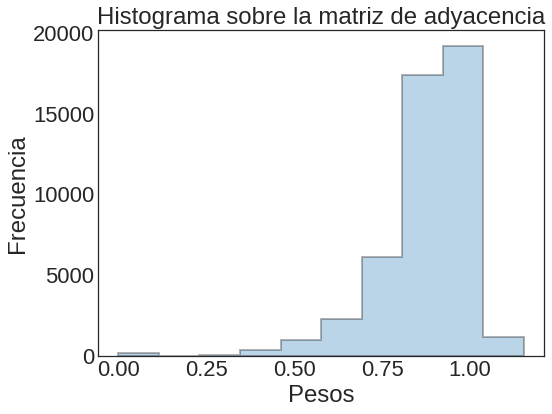

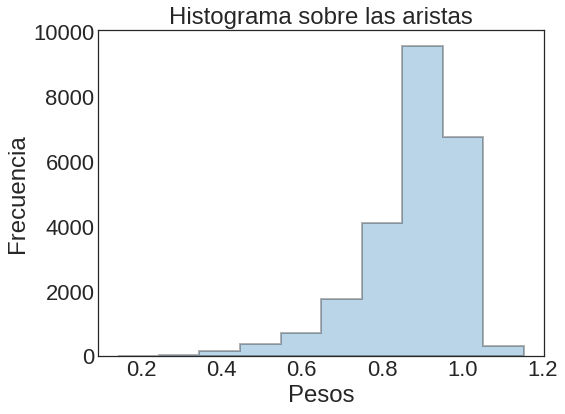

In [42]:
#Histograma de los pesos en la red 

plt.style.use('seaborn-white')
kwargs = dict(histtype='stepfilled', alpha=0.3, ec="k")
plt.figure()
plt.hist(distancias_w2v_dict.flatten(),**kwargs)
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma sobre la matriz de adyacencia')

plt.figure()
nodo_salida = [n1 for n1, n2, att in G_w2v.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_w2v.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_w2v.edges(data=True)]
plt.hist(weights,**kwargs);
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma sobre las aristas');

In [43]:
# Análisis de red
print(nx.info(G_w2v))
print('Pesada:',nx.is_weighted(G_w2v))
print('Dirigido:',nx.is_directed(G_w2v))
print('Nro de nodos: ',G_w2v.number_of_nodes())
print('Cantidad de aristas: ', G_w2v.number_of_edges())
K=[]
for i in G_w2v:
  K.append(is_self_looped(G_w2v,i))
print('Cantidad de loops: ',sum(K))

Graph with 219 nodes and 23871 edges
Pesada: True
Dirigido: False
Nro de nodos:  219
Cantidad de aristas:  23871
Cantidad de loops:  0


In [44]:
#grado de los nodos
print(G_w2v.degree)
df_n = pd.DataFrame(G_w2v.degree,columns=['Node','Degree']).set_index('Node')
print(df_n.T)
#ordenados
print(df_n.sort_values('Degree',ascending=False).T)

[(0, 218), (1, 218), (2, 218), (3, 218), (4, 218), (5, 218), (6, 218), (7, 218), (8, 218), (9, 218), (10, 218), (11, 218), (12, 218), (13, 218), (14, 218), (15, 218), (16, 218), (17, 218), (18, 218), (19, 218), (20, 218), (21, 218), (22, 218), (23, 218), (24, 218), (25, 218), (26, 218), (27, 218), (28, 218), (29, 218), (30, 218), (31, 218), (32, 218), (33, 218), (34, 218), (35, 218), (36, 218), (37, 218), (38, 218), (39, 218), (40, 218), (41, 218), (42, 218), (43, 218), (44, 218), (45, 218), (46, 218), (47, 218), (48, 218), (49, 218), (50, 218), (51, 218), (52, 218), (53, 218), (54, 218), (55, 218), (56, 218), (57, 218), (58, 218), (59, 218), (60, 218), (61, 218), (62, 218), (63, 218), (64, 218), (65, 218), (66, 218), (67, 218), (68, 218), (69, 218), (70, 218), (71, 218), (72, 218), (73, 218), (74, 218), (75, 218), (76, 218), (77, 218), (78, 218), (79, 218), (80, 218), (81, 218), (82, 218), (83, 218), (84, 218), (85, 218), (86, 218), (87, 218), (88, 218), (89, 218), (90, 218), (91, 218

Text(0.5, 1.0, 'spring')

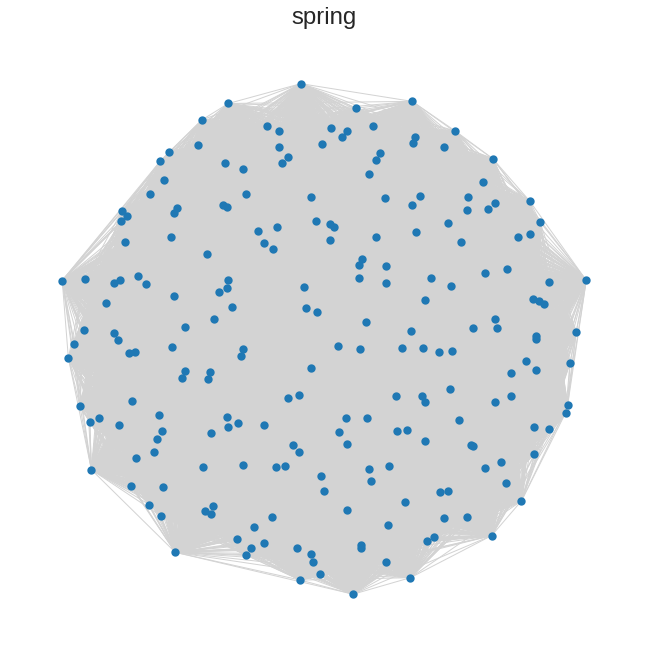

In [45]:
# Visualización
plt.figure(figsize=(25,25))
plt.subplot(221)
nx.draw(G_w2v, with_labels=False,edge_color='lightgray',node_size=40)
plt.title('spring')

#plt.subplot(222)
#layout=nx.kamada_kawai_layout(G_w2v)
#nx.draw(G_w2v,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('Kamada Kawai')
#plt.subplot(223)
#layout=nx.circular_layout(G_w2v)
#nx.draw(G_w2v,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('circular');
#plt.subplot(224)
#layout=nx.random_layout(G_w2v)
#nx.draw(G_w2v,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('random');

## Grafo Gw2v con filtro de enlaces 

In [46]:
# Dado que hay muchísima cantidad de enlaces, se filtra el grafo
new_dist = distancias_w2v_dict.copy()
new_dist[new_dist<=np.quantile(new_dist, 0.92)] = 0.0 

G_w2v_umbral =nx.from_numpy_matrix(new_dist)

#largest_cc2 = max(nx.connected_components(G_w2v_umbral_ant), key=len)
#G_w2v_umbral = G_w2v.subgraph(G_w2v_umbral_ant).copy() 
#print(nx.info(G_w2v_umbral))

Text(0.5, 1.0, 'Nueva matriz de distancias')

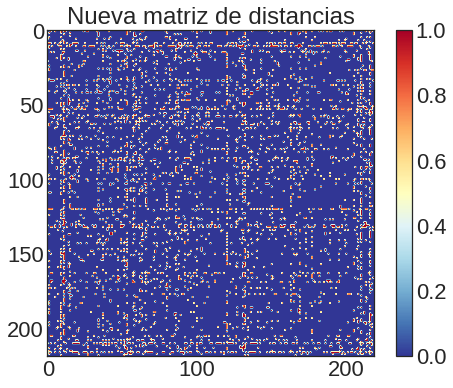

In [47]:
plt.imshow(new_dist,cmap='RdYlBu_r',vmax=1)
plt.colorbar()
plt.title('Nueva matriz de distancias')

## Caracterización de grafo Gw2v filtrado

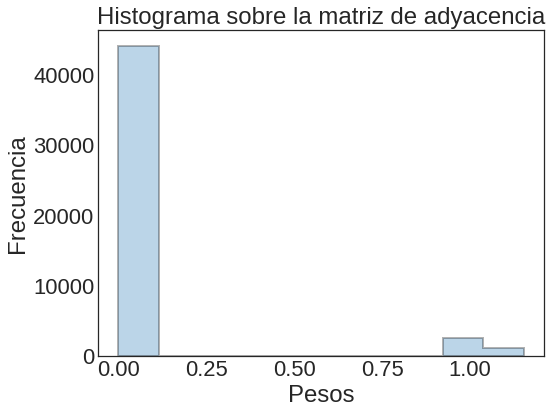

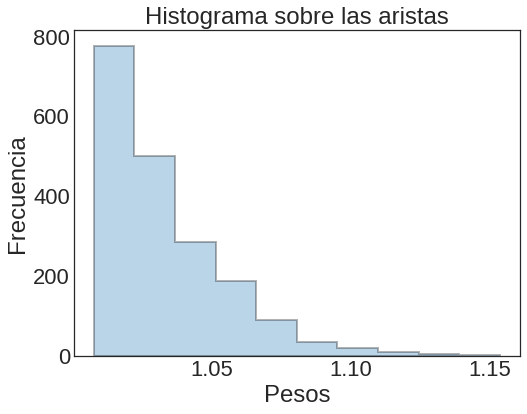

In [48]:
#Histograma de los pesos 

plt.figure()

plt.hist(new_dist.flatten(), **kwargs)
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma sobre la matriz de adyacencia')

plt.figure()
nodo_salida = [n1 for n1, n2, att in G_w2v_umbral.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_w2v_umbral.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_w2v_umbral.edges(data=True)]
plt.hist(weights,**kwargs);
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma sobre las aristas');

In [49]:
# Análisis de red
print(nx.info(G_w2v_umbral))
print('Pesada:',nx.is_weighted(G_w2v_umbral))
print('Dirigido:',nx.is_directed(G_w2v_umbral))
print('Nro de nodos: ',G_w2v_umbral.number_of_nodes())
print('Cantidad de aristas: ', G_w2v_umbral.number_of_edges())
K=[]
for i in G_w2v_umbral:
  K.append(is_self_looped(G_w2v_umbral,i))
print('Tienen multiples aristas:',G_w2v_umbral.is_multigraph())
print('Cantidad de loops: ',sum(K))
print('Está conectada?: ',nx.is_connected(G_w2v_umbral))

Graph with 219 nodes and 1918 edges
Pesada: True
Dirigido: False
Nro de nodos:  219
Cantidad de aristas:  1918
Tienen multiples aristas: False
Cantidad de loops:  0
Está conectada?:  True


In [50]:
#grado de los nodos
print(G_w2v_umbral.degree)
df_n = pd.DataFrame(G_w2v_umbral.degree,columns=['Node','Degree']).set_index('Node')
print(df_n.T)
#ordenados
print(df_n.sort_values('Degree',ascending=False).T)

[(0, 13), (1, 38), (2, 19), (3, 13), (4, 4), (5, 15), (6, 14), (7, 11), (8, 8), (9, 70), (10, 16), (11, 101), (12, 12), (13, 10), (14, 34), (15, 33), (16, 15), (17, 11), (18, 21), (19, 17), (20, 20), (21, 19), (22, 10), (23, 9), (24, 15), (25, 8), (26, 20), (27, 19), (28, 2), (29, 11), (30, 7), (31, 10), (32, 12), (33, 20), (34, 42), (35, 8), (36, 9), (37, 36), (38, 15), (39, 13), (40, 19), (41, 14), (42, 31), (43, 16), (44, 12), (45, 7), (46, 10), (47, 34), (48, 13), (49, 29), (50, 11), (51, 21), (52, 29), (53, 64), (54, 8), (55, 12), (56, 14), (57, 27), (58, 45), (59, 23), (60, 10), (61, 20), (62, 32), (63, 35), (64, 14), (65, 12), (66, 41), (67, 6), (68, 10), (69, 10), (70, 7), (71, 22), (72, 22), (73, 17), (74, 9), (75, 10), (76, 10), (77, 16), (78, 13), (79, 17), (80, 29), (81, 8), (82, 28), (83, 12), (84, 6), (85, 15), (86, 34), (87, 32), (88, 19), (89, 20), (90, 11), (91, 11), (92, 31), (93, 15), (94, 18), (95, 11), (96, 22), (97, 15), (98, 13), (99, 10), (100, 35), (101, 14), (

Text(0.5, 1.0, 'spring')

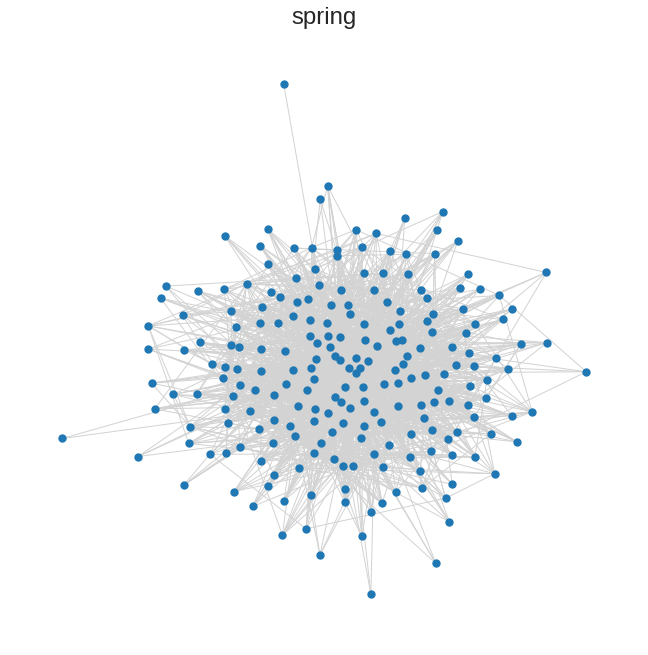

In [51]:
# Visualización de la red Gw2v filtrada 

plt.figure(figsize=(25,25))
plt.subplot(221)
nx.draw(G_w2v_umbral, with_labels=False,edge_color='lightgray',node_size=40)
plt.title('spring')

#plt.subplot(222)
#layout=nx.kamada_kawai_layout(G_w2v_umbral)
#nx.draw(G_w2v_umbral,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('Kamada Kawai')
#plt.subplot(223)
#layout=nx.circular_layout(G_w2v_umbral)
#nx.draw(G_w2v_umbral,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('circular');
#plt.subplot(224)
#layout=nx.random_layout(G_w2v_umbral)
#nx.draw(G_w2v_umbral,layout, with_labels=True,edge_color='lightgray',node_size=200)
#plt.title('random');

In [52]:
G_w2v_umbral.degree

DegreeView({0: 13, 1: 38, 2: 19, 3: 13, 4: 4, 5: 15, 6: 14, 7: 11, 8: 8, 9: 70, 10: 16, 11: 101, 12: 12, 13: 10, 14: 34, 15: 33, 16: 15, 17: 11, 18: 21, 19: 17, 20: 20, 21: 19, 22: 10, 23: 9, 24: 15, 25: 8, 26: 20, 27: 19, 28: 2, 29: 11, 30: 7, 31: 10, 32: 12, 33: 20, 34: 42, 35: 8, 36: 9, 37: 36, 38: 15, 39: 13, 40: 19, 41: 14, 42: 31, 43: 16, 44: 12, 45: 7, 46: 10, 47: 34, 48: 13, 49: 29, 50: 11, 51: 21, 52: 29, 53: 64, 54: 8, 55: 12, 56: 14, 57: 27, 58: 45, 59: 23, 60: 10, 61: 20, 62: 32, 63: 35, 64: 14, 65: 12, 66: 41, 67: 6, 68: 10, 69: 10, 70: 7, 71: 22, 72: 22, 73: 17, 74: 9, 75: 10, 76: 10, 77: 16, 78: 13, 79: 17, 80: 29, 81: 8, 82: 28, 83: 12, 84: 6, 85: 15, 86: 34, 87: 32, 88: 19, 89: 20, 90: 11, 91: 11, 92: 31, 93: 15, 94: 18, 95: 11, 96: 22, 97: 15, 98: 13, 99: 10, 100: 35, 101: 14, 102: 5, 103: 33, 104: 7, 105: 8, 106: 12, 107: 14, 108: 15, 109: 15, 110: 10, 111: 1, 112: 17, 113: 6, 114: 14, 115: 8, 116: 5, 117: 9, 118: 14, 119: 4, 120: 65, 121: 10, 122: 15, 123: 12, 124: 

# **Tarea 2: Caracterización _completa_ de grafos**

## Caracterización

▶ DIAMETRO
diametro gsww: 19 
diametro gw2v:  4 

▶ DENSIDAD
densidad gsww:  0.0093 
densidad gw2v:  0.0803 

▶ CLUSTERING PROMEDIO
clustering promedio gsww:  0.0247 
clustering promedio gw2v:  0.0959 

▶ ASORTIVIDAD
asortividad gsww:  -0.4769 
asortividad gw2v:  -0.3679 

▶ CAMINO MÍNIMO PROMEDIO
camino mínimo gsww: 8.26 
camino mínimo gw2v:  2.093 



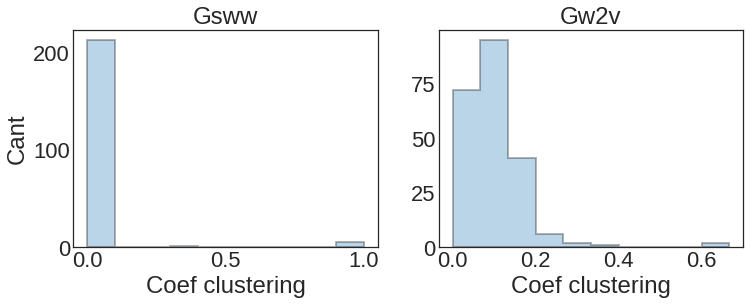

In [53]:
# Medidas de centralidad

#diametro 
print('▶ DIAMETRO')
print('diametro gsww:', round(nx.diameter(G_sample),4),
      '\ndiametro gw2v: ' ,round(nx.diameter(G_w2v_umbral),4),'\n')

#densidad
print('▶ DENSIDAD')
print('densidad gsww: ' ,round(nx.density(G_sample),4),
      '\ndensidad gw2v: ' ,round(nx.density(G_w2v_umbral),4),'\n')

#clustering promedio 
print('▶ CLUSTERING PROMEDIO')
print('clustering promedio gsww: ' ,round(nx.average_clustering(G_sample),4)
, '\nclustering promedio gw2v: ' ,round(nx.average_clustering(G_w2v_umbral),4),'\n')                                                   
                                                    
#asortividad
print('▶ ASORTIVIDAD')
print('asortividad gsww: ' ,round(nx.degree_assortativity_coefficient(G_sample),4)
,        '\nasortividad gw2v: ' ,round(nx.degree_assortativity_coefficient(G_w2v_umbral),4),'\n') 

#camino mínimo
print('▶ CAMINO MÍNIMO PROMEDIO')
print('camino mínimo gsww:', round(nx.average_shortest_path_length(G_sample),4), 
       '\ncamino mínimo gw2v: ' ,round(nx.average_shortest_path_length(G_w2v_umbral),4),'\n') 


#coef clustering NODO
kwargs = dict(histtype='stepfilled', alpha=0.3, ec="k")
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(nx.clustering(G_sample).values(),**kwargs)
plt.title("Gsww")
plt.xlabel('Coef clustering')
plt.ylabel('Cantidad');
plt.subplot(122)
plt.hist(nx.clustering(G_w2v_umbral).values(),**kwargs)
plt.title("Gw2v")
plt.xlabel('Coef clustering');


distintas medidas de centralidad, distribución de pesos, distribución de grado, camino mínimo ¿Qué pueden decir de cada uno de los grafos? ¿Y qué pueden decir de la comparación entre ellos?

CENTRALIDAD BETWEENESS



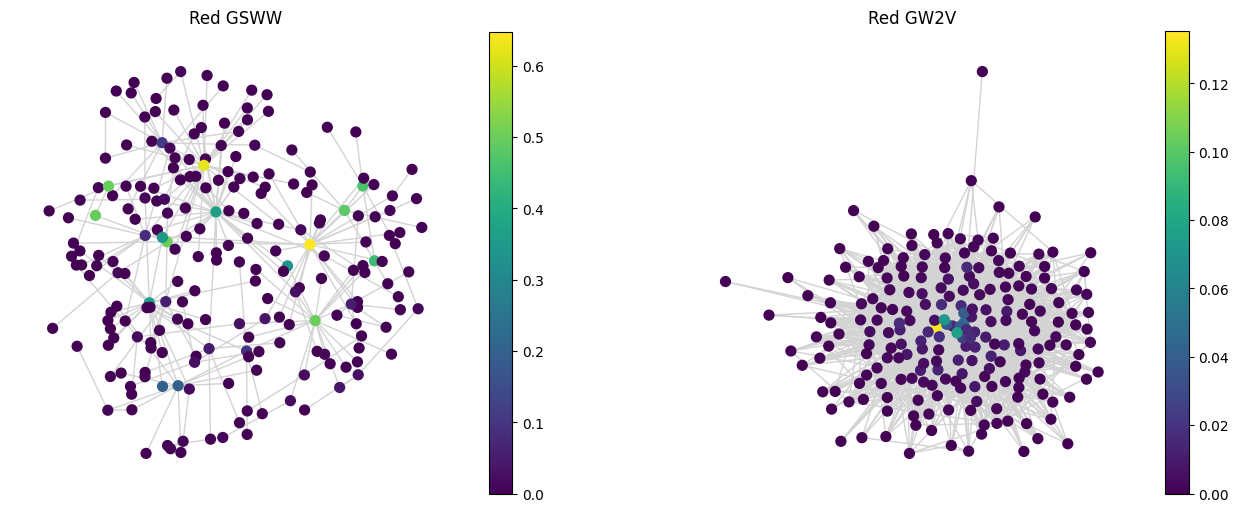

In [54]:
print('CENTRALIDAD BETWEENESS\n')
mpl.rcParams.update(mpl.rcParamsDefault)
pos_sample = nx.spring_layout(G_sample,k=0.2)
pos_vect = nx.spring_layout(G_w2v_umbral,k=0.2)

fig, axs = plt.subplots(1,2,figsize=(16,6))

values = [v for v in nx.betweenness_centrality(G_sample).values()]
nx.draw(G_sample,pos=pos_sample, node_size=50,with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red GSWW')

values = [v for v in nx.betweenness_centrality(G_w2v_umbral).values()]
nx.draw(G_w2v_umbral,pos=pos_vect,node_size=50, with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[1])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
axs[1].set_title('Red GW2V');

CENTRALIDAD de GRADO



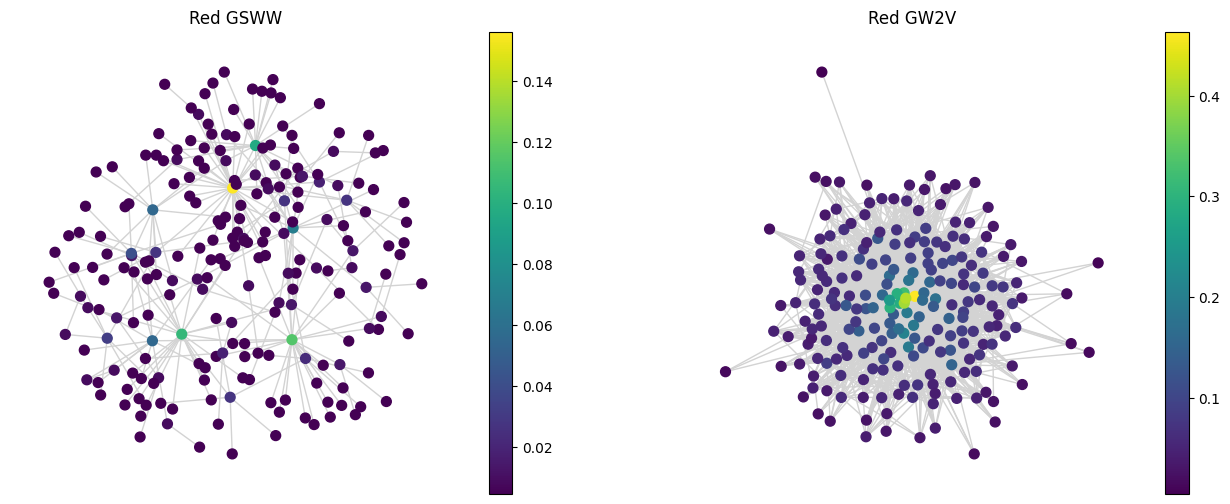

In [55]:
print('CENTRALIDAD de GRADO\n')
pos_sample = nx.spring_layout(G_sample,k=0.2)
pos_vect = nx.spring_layout(G_w2v_umbral,k=0.2)

fig, axs = plt.subplots(1,2,figsize=(16,6))

values = [v for v in nx.degree_centrality(G_sample).values()]
nx.draw(G_sample,pos=pos_sample, node_size=50,with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red GSWW')

values = [v for v in nx.degree_centrality(G_w2v_umbral).values()]
nx.draw(G_w2v_umbral,pos=pos_vect,node_size=50, with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[1])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
axs[1].set_title('Red GW2V');

CENTRALIDAD de CERCANÍA



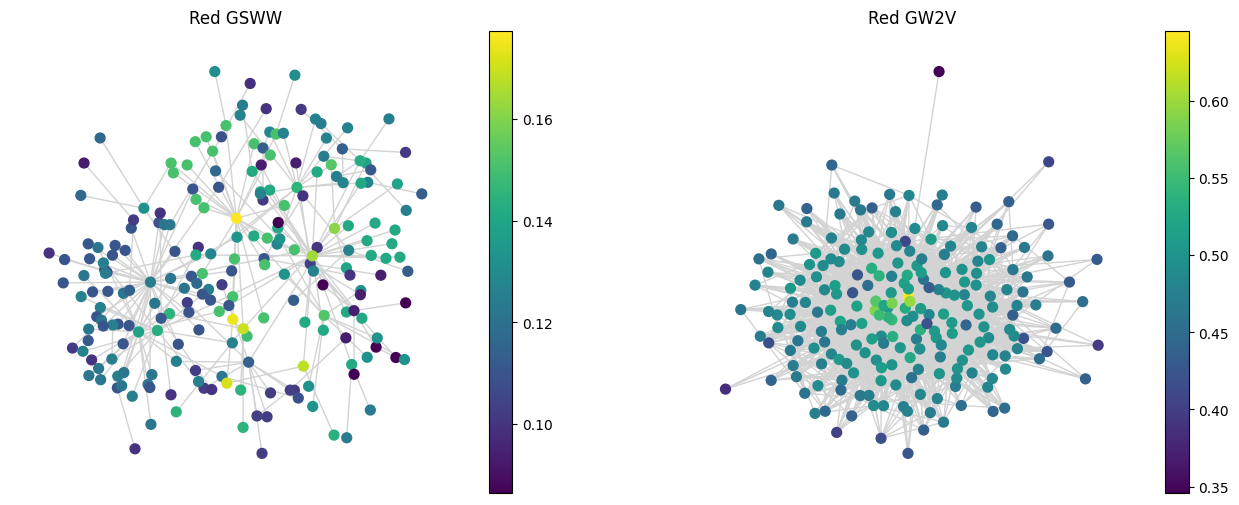

In [56]:
print('CENTRALIDAD de CERCANÍA\n')
pos_sample = nx.spring_layout(G_sample,k=0.2)
pos_vect = nx.spring_layout(G_w2v_umbral,k=0.2)

fig, axs = plt.subplots(1,2,figsize=(16,6))

values = [v for v in nx.closeness_centrality(G_sample).values()]
nx.draw(G_sample,pos=pos_sample, node_size=50,with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red GSWW')

values = [v for v in nx.closeness_centrality(G_w2v_umbral).values()]
nx.draw(G_w2v_umbral,pos=pos_vect,node_size=50, with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[1])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
axs[1].set_title('Red GW2V');

CENTRALIDAD de AUTOVALOR



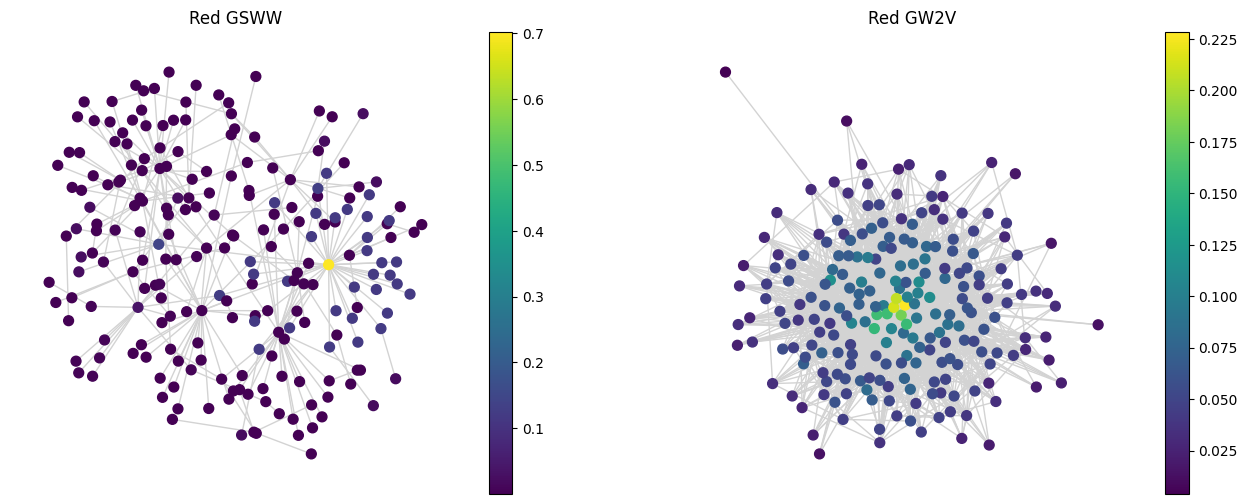

In [57]:
print('CENTRALIDAD de AUTOVALOR\n')
pos_sample = nx.spring_layout(G_sample,k=0.2)
pos_vect = nx.spring_layout(G_w2v_umbral,k=0.2)

fig, axs = plt.subplots(1,2,figsize=(16,6))

values = [v for v in nx.eigenvector_centrality(G_sample).values()]
nx.draw(G_sample,pos=pos_sample, node_size=50,with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red GSWW')

values = [v for v in nx.eigenvector_centrality(G_w2v_umbral).values()]
nx.draw(G_w2v_umbral,pos=pos_vect,node_size=50, with_labels=False,node_color = values, font_color='white', edge_color='lightgray',ax=axs[1])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
axs[1].set_title('Red GW2V');

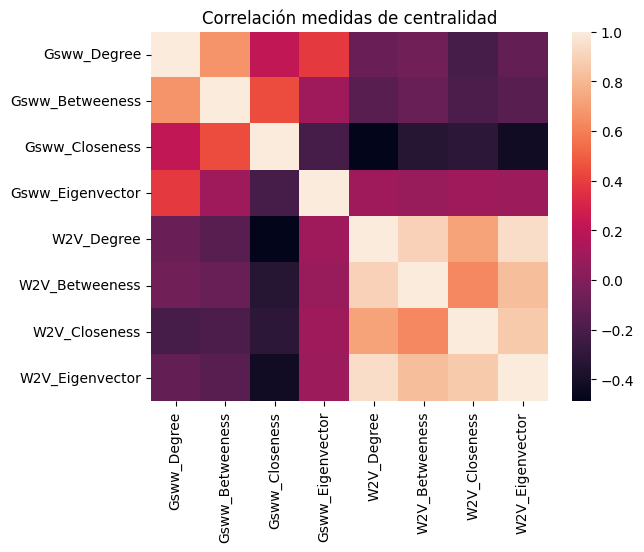

In [58]:
X = [nx.degree_centrality(G_sample).values(),nx.betweenness_centrality(G_sample).values(),nx.closeness_centrality(G_sample).values(),nx.eigenvector_centrality(G_sample).values() ]
df_centralidad_obs = pd.DataFrame(X,index=['Gsww_Degree','Gsww_Betweeness','Gsww_Closeness','Gsww_Eigenvector']).T
X = [nx.degree_centrality(G_w2v_umbral).values(),nx.betweenness_centrality(G_w2v_umbral).values(),nx.closeness_centrality(G_w2v_umbral).values(),nx.eigenvector_centrality(G_w2v_umbral).values() ]
df_centralidad_per = pd.DataFrame(X,index=['W2V_Degree','W2V_Betweeness','W2V_Closeness','W2V_Eigenvector']).T
sns.heatmap(df_centralidad_obs.join(df_centralidad_per).corr())
plt.title('Correlación medidas de centralidad');

Text(0.5, 1.0, 'Histograma pesos GW2V')

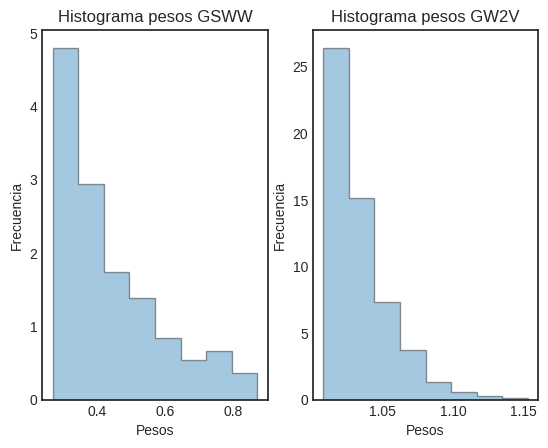

In [174]:
# Distribución de pesos

plt.style.use('seaborn-white')
kwargs = dict(histtype='stepfilled', alpha=0.4, ec="k",bins=8,density=True)


plt.subplot(121)
nodo_salida = [n1 for n1, n2, att in G_sample.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_sample.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_sample.edges(data=True)]
plt.hist(weights,**kwargs);
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma pesos GSWW');


plt.subplot(122)
nodo_salida = [n1 for n1, n2, att in G_w2v_umbral.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_w2v_umbral.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_w2v_umbral.edges(data=True)]
plt.hist(weights,**kwargs);
plt.ylabel('Frecuencia')
plt.xlabel('Pesos');
plt.title('Histograma pesos GW2V')



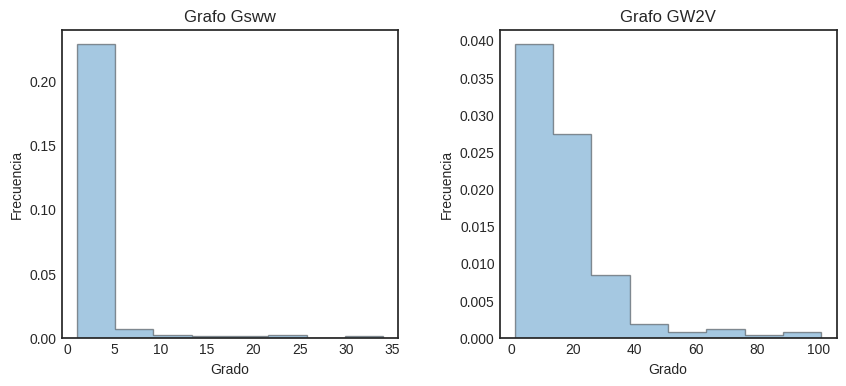

In [178]:
# Distribución de grado
df_Gs_grado = pd.DataFrame(G_sample.degree,columns=['Node','Degree']).set_index('Node')
df_Gw2v_grado = pd.DataFrame(G_w2v_umbral.degree,columns=['Node','Degree']).set_index('Node')

plt.figure(figsize=(10,4))
df_Gs_grado.hist(ax=plt.subplot(121),label='Gsww',**kwargs, grid=False);
plt.title('Grafo Gsww')
plt.xlabel('Grado')
plt.ylabel('Frecuencia');
df_Gw2v_grado.hist(ax=plt.subplot(122),label='GW2V',**kwargs, grid=False);
plt.title('Grafo GW2V')
plt.xlabel('Grado')
plt.ylabel('Frecuencia');

<Figure size 800x400 with 0 Axes>

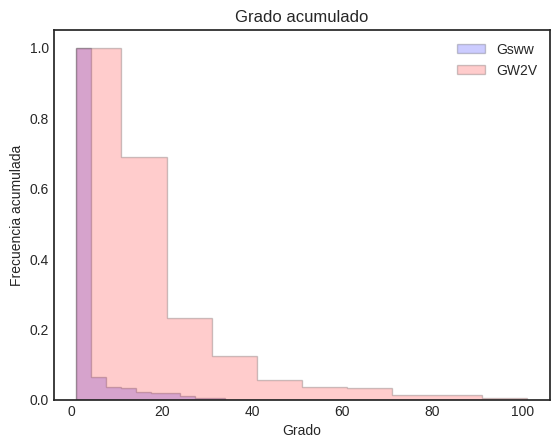

In [61]:
kwargs = dict(alpha=0.2, ec="k", grid=False,histtype='stepfilled',density=True)

plt.figure(figsize=(8,4));
df_Gs_grado.hist(label='Gsww', cumulative=-1, **kwargs, color='blue');
df_Gw2v_grado.hist(ax=plt.gca() ,label='GW2V', cumulative=-1, **kwargs, color='red');
plt.title('Grado acumulado')
plt.xlabel('Grado')
plt.ylabel('Frecuencia acumulada')
plt.legend();

# **Tarea 3: Comunidades**

* Detectar comunidades en Gsww y Gw2v con el algoritmo que consideren más  indicado (justificar por qué)

* Calcular el indice de modularidad en cada caso ¿Qué pueden decir de las
comunidades?

* Comparar las comunidades de ambas redes con el índice rand (u otra métrica que considere adecuada) ¿Son similares?

* Visualizar uno de los grafos, y pintarlo según las comunidades del otro ¿Qué se puede decir?

* También se puede analizar la resolución del algoritmo de por el cuál se detectan las comunidades. Para ello, pueden explorar estructuras dentro de alguna de las comunidades.

In [62]:
import community
import powerlaw

from sklearn.metrics import adjusted_rand_score
from networkx.algorithms.community import modularity
from networkx.algorithms import community
import community.community_louvain as community_louvain

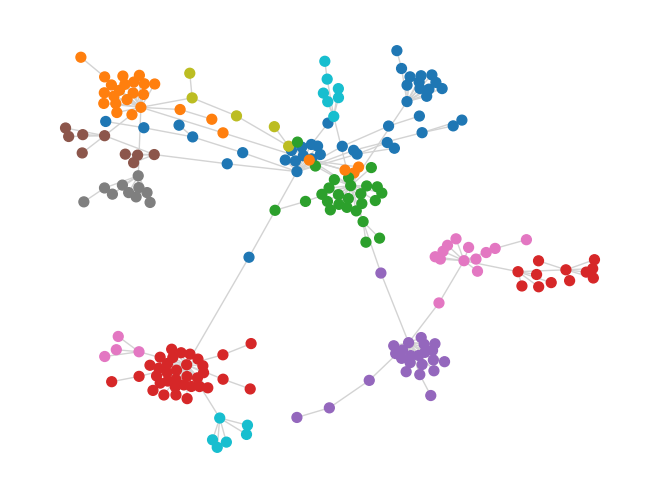

In [179]:
# louvain sólo acepta no dirigidas
pos_usample = nx.spring_layout(G_sample)
modulos = community_louvain.best_partition(G_sample) 
values_ug = [v for n,v in modulos.items()]
nx.draw(G_sample,pos=pos_usample, with_labels=False,cmap=plt.cm.tab10,node_color = values_ug, font_size=6,font_color='gray', edge_color='lightgray', node_size=50)

Text(0.5, 1.0, 'COMUNIDADES\nLouvain en GW2V\n(color: comunidades en Gsww)')

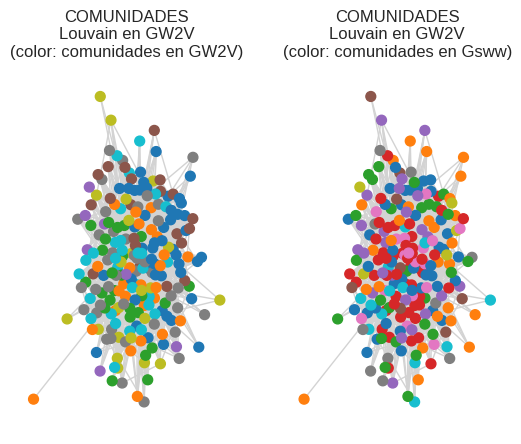

In [186]:
pos_Uvect = nx.spring_layout(G_w2v_umbral,k=0.2)
modulos1 = community_louvain.best_partition(G_w2v_umbral) 
values_UGW2V = [v for n,v in modulos1.items()]


plt.subplot(121)
nx.draw(G_w2v_umbral,pos=pos_Uvect, with_labels=False,cmap=plt.cm.tab10,node_color = values_UGW2V, font_size=6,font_color='gray', edge_color='lightgray', node_size=50)
plt.title('COMUNIDADES\nLouvain en GW2V\n(color: comunidades en GW2V)')
plt.subplot(122)
nx.draw(G_w2v_umbral,pos=pos_Uvect, with_labels=False,cmap=plt.cm.tab10,node_color = values_ug, font_size=6,font_color='gray', edge_color='lightgray', node_size=50)
plt.title('COMUNIDADES\nLouvain en GW2V\n(color: comunidades en Gsww)')

In [65]:
adjusted_rand_score(values_ug, values_UGW2V)

0.006125577326664891

## Tarea opcional 4 
ubico palabras de w2v3 según su distancia y coloreo según las comunidades a las que pertenecen

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


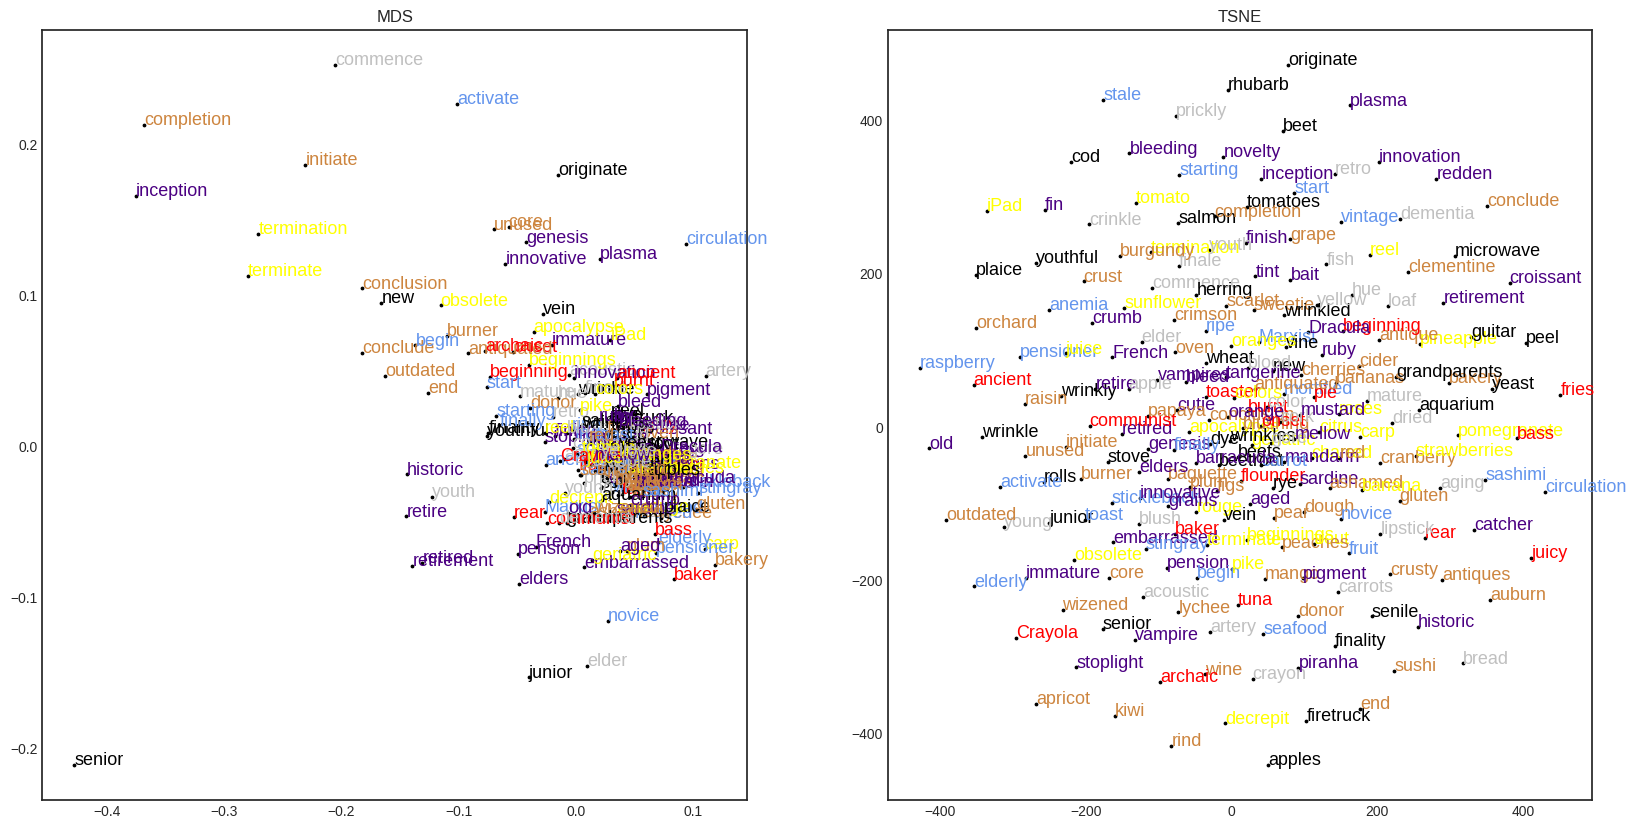

In [66]:
colors= ['red','cornflowerblue','indigo','yellow','black','silver','peru','green','magenta','indianred']
visualize_embeddings(new_dist,w2v_words3,np.array(colors)[values_UGW2V],perplexity=3)

# **Tarea 4: _Small-world_ y redes prototípicas**

Existen trabajos previos que muestran que tanto la red de asociaciones (Gsww) como la
red semántica (Gw2v) tienen estructura de small-world [5, 6]. Comparar las características
de redes, como el camino mínimo, con distintos modelos de redes, en particular con redes
3
small-world. Para ello generar N redes small-world con el mismo número de nodos y aristas, y evaluar si las características medidas en Gsww y Gw2v podrían pertenecer a dichas
distribuciones.

In [ ]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}
    G = nx.barabasi_albert_graph(G_w2v_umbral.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_path'] = nx.average_shortest_path_length(G)
    d['ba_avg_degree'] = G.number_of_edges()/G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G.degree],discrete=True,xmin=8).alpha

    G = nx.gnm_random_graph(G_w2v_umbral.number_of_nodes(),G_w2v_umbral.number_of_edges(),seed=i)    
    d['er_avg_clus'] = nx.average_clustering(G)
    d['er_avg_path'] = nx.average_shortest_path_length(G)
    
    G = nx.newman_watts_strogatz_graph(G_w2v_umbral.number_of_nodes(),round(G.number_of_edges()/G.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_path'] = nx.average_shortest_path_length(G)
    data.append(d)

df1 = pd.DataFrame(data)
#axs = df1.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
#for ax in axs.flatten():
#    ax.vlines(nx.average_clustering(G_w2v_umbral),0,20,lw=3,color='r')
#
#axs = df1.filter(regex='avg_path').hist(figsize=(12,8),density=True)
#for ax in axs.flatten():
#    ax.vlines(nx.average_shortest_path_length(G_w2v_umbral),0,20,lw=3,color='r')

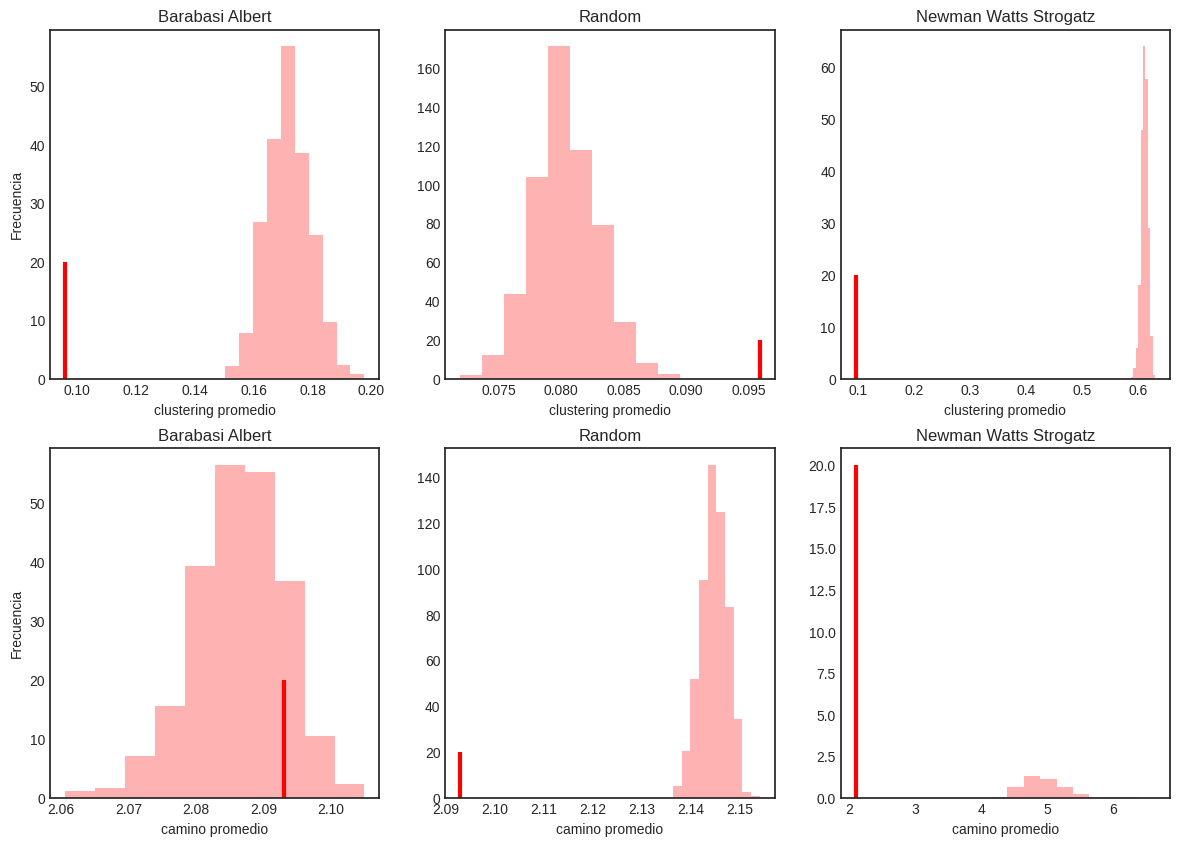

In [171]:
plt.subplot(231)
plt.hist(df1.ba_avg_clus,color='red', density=True, alpha=0.3)
#plt.hist(df2.ba_avg_clus,color='blue', density=True, alpha=0.3)
#plt.vlines(x=nx.average_clustering(G_sample),ymin= 0,ymax=20,lw=3,color='b')
plt.ylabel('Frecuencia')
plt.xlabel('clustering promedio');
plt.title('Barabasi Albert')
plt.vlines(x=nx.average_clustering(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplot(232)
plt.hist(df1.er_avg_clus, color='red', density=True,alpha=0.3)
plt.xlabel('clustering promedio');
plt.title('Random')
plt.vlines(x=nx.average_clustering(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplot(233)
plt.hist(df1.ws_avg_clus, color='red', density=True,alpha=0.3)
#plt.hist(df2.ws_avg_clus, color='blue', density=True,alpha=0.3)
#plt.vlines(x=nx.average_clustering(G_sample),ymin= 0,ymax=20,lw=3,color='b')
plt.xlabel('clustering promedio');
plt.title('Newman Watts Strogatz')
plt.vlines(x=nx.average_clustering(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplot(234)
plt.hist(df1.ba_avg_path,color='red', density=True, alpha=0.3)
#plt.hist(df2.ba_avg_path,color='blue', density=True, alpha=0.3)
#plt.vlines(x=nx.average_shortest_path_length(G_sample),ymin= 0,ymax=20,lw=3,color='b')
plt.ylabel('Frecuencia')
plt.xlabel('camino promedio');
plt.title('Barabasi Albert')
plt.vlines(x=nx.average_shortest_path_length(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplot(235)
plt.hist(df1.er_avg_path, color='red', density=True,alpha=0.3)

plt.xlabel('camino promedio');
plt.title('Random')
plt.vlines(x=nx.average_shortest_path_length(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplot(236)
plt.hist(df1.ws_avg_path, color='red', density=True,alpha=0.3)
#plt.hist(df2.ws_avg_path, color='blue', density=True,alpha=0.3)
#plt.vlines(x=nx.average_shortest_path_length(G_sample),ymin= 0,ymax=20,lw=3,color='b')
plt.xlabel('camino promedio');
plt.title('Newman Watts Strogatz')
plt.vlines(x=nx.average_shortest_path_length(G_w2v_umbral),ymin= 0,ymax=20,lw=3,color='r')

plt.subplots_adjust(left=0.25, bottom=1, right=2 , top=2.6 , wspace=0.2, hspace=0.2 )

Text(0.5, 1.0, 'Comparación de medidas con\nredes de small world')

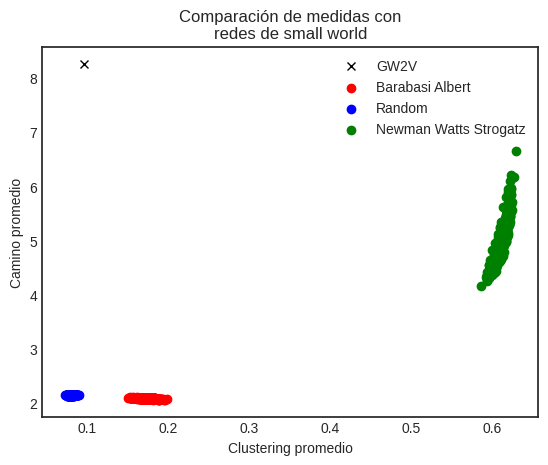

In [162]:
for key,color in zip(['ba','er','ws'],['r','b','g']):
  plt.scatter(df1[key+'_avg_clus'], df1[key+'_avg_path'],color=color,label=key)
plt.plot(nx.average_clustering(G_w2v_umbral), nx.average_shortest_path_length(G_sample),'xk',label='Red Gw2V')
plt.legend(['GW2V','Barabasi Albert', 'Random','Newman Watts Strogatz'])
plt.ylabel('Camino promedio')
plt.xlabel('Clustering promedio')
plt.title('Comparación de medidas con\nredes de small world')

In [ ]:
repetitions = 1000
data2 = []
for i in range(repetitions):
    d = {}
    G = nx.barabasi_albert_graph(G_sample.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_path'] = nx.average_shortest_path_length(G)
    d['ba_avg_degree'] = G.number_of_edges()/G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G.degree],discrete=True,xmin=8).alpha

    #G = nx.gnm_random_graph(G_sample.number_of_nodes(),G_sample.number_of_edges(),seed=i)    
    #d['er_avg_clus'] = nx.average_clustering(G)
    #d['er_avg_path'] = nx.average_shortest_path_length(G)
    
    G = nx.newman_watts_strogatz_graph(G_sample.number_of_nodes(),round(G.number_of_edges()/G.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_path'] = nx.average_shortest_path_length(G)
    data2.append(d)

df2 = pd.DataFrame(data2)
#axs = df2.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
#for ax in axs.flatten():
#    ax.vlines(nx.average_clustering(G_sample),0,20,lw=3,color='r')

#axs = df2.filter(regex='avg_path').hist(figsize=(12,8),density=True)
#for ax in axs.flatten():
#    ax.vlines(nx.average_shortest_path_length(G_sample),0,20,lw=3,color='r')

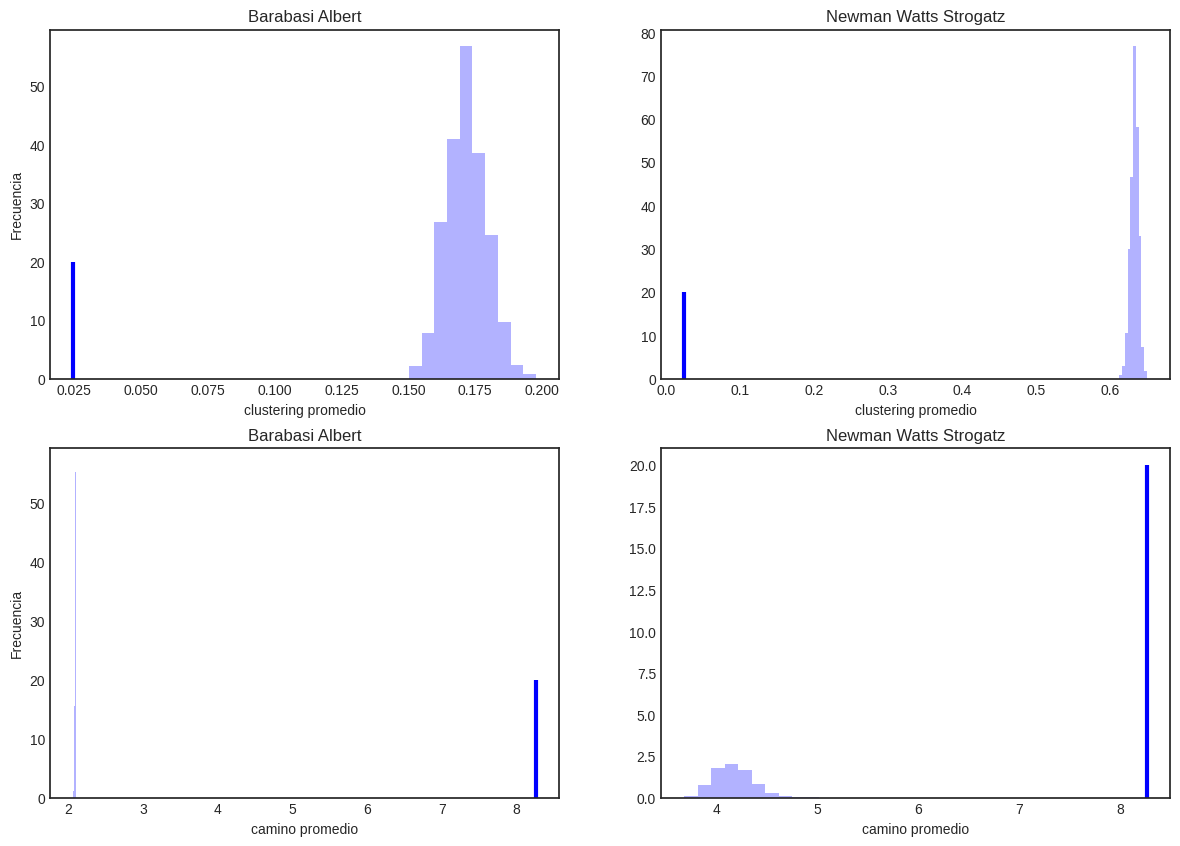

In [165]:
plt.subplot(221)
plt.hist(df2.ba_avg_clus,color='blue', density=True, alpha=0.3)
plt.ylabel('Frecuencia')
plt.xlabel('clustering promedio');
plt.title('Barabasi Albert')
plt.vlines(x=nx.average_clustering(G_sample),ymin= 0,ymax=20,lw=3,color='b')

plt.subplot(222)
plt.hist(df2.ws_avg_clus, color='blue', density=True,alpha=0.3)
plt.xlabel('clustering promedio');
plt.title('Newman Watts Strogatz')
plt.vlines(x=nx.average_clustering(G_sample),ymin= 0,ymax=20,lw=3,color='b')

plt.subplot(223)
plt.hist(df2.ba_avg_path,color='blue', density=True, alpha=0.3)
plt.ylabel('Frecuencia')
plt.xlabel('camino promedio');
plt.title('Barabasi Albert')
plt.vlines(x=nx.average_shortest_path_length(G_sample),ymin= 0,ymax=20,lw=3,color='b')


plt.subplot(224)
plt.hist(df2.ws_avg_path, color='blue', density=True,alpha=0.3)
plt.xlabel('camino promedio');
plt.title('Newman Watts Strogatz')
plt.vlines(x=nx.average_shortest_path_length(G_sample),ymin= 0,ymax=20,lw=3,color='b')

plt.subplots_adjust(left=0.25, bottom=1, right=2 , top=2.6 , wspace=0.2, hspace=0.2 )

Text(0.5, 1.0, 'Comparación de medidas con\nredes de small world')

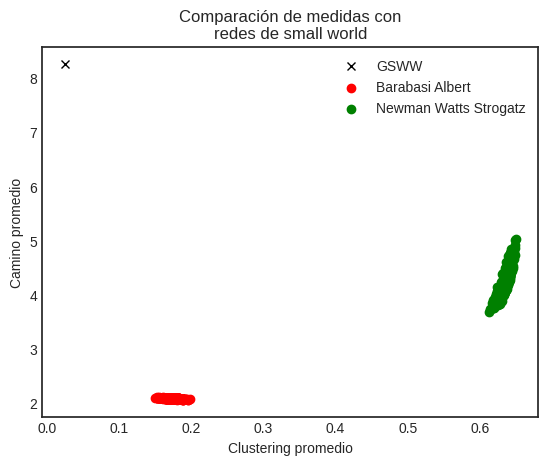

In [187]:
for key,color in zip(['ba','ws'],['r','g']):
  plt.scatter(df2[key+'_avg_clus'], df2[key+'_avg_path'],color=color,label=key)
plt.plot(nx.average_clustering(G_sample), nx.average_shortest_path_length(G_sample),'xk',label='Red GSWW')
plt.legend(['GSWW','Barabasi Albert','Newman Watts Strogatz'])
plt.ylabel('Camino promedio')
plt.xlabel('Clustering promedio')
plt.title('Comparación de medidas con\nredes de small world')

Análisis libre de escala

In [104]:
degree_gsww = [d for n, d in G_sample.degree]
gsww_fit = powerlaw.Fit(degree_gsww, fit_method='KS', discrete=True, xmin=9)
gsww_fit.alpha, gsww_fit.D, gsww_fit.xmin

(2.40849737975019, 0.22115248410872007, 9.0)

In [87]:
%load_ext rpy2.ipython

In [106]:
%%R -i degree_gsww -o out
if(!require(igraph)) install.packages("igraph");  require(igraph)
out<-power.law.fit(degree_gsww,xmin =17)
print(out$alpha)
print(out$KS.p)

[1] 3.34145
[1] 0.55002
